In [1]:
from itertools import combinations
from transformers import AutoTokenizer
from ollama_interact import interact_with_ollama
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

/opt/anaconda3/envs/opensora/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Hermes-2-Theta-Llama-3-8B")

/opt/anaconda3/envs/opensora/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
%%time
prompt = "Should I move to a new company?"
baseline_text, response = interact_with_ollama(
    model='llama3',
    prompt=prompt,
    api_url='http://192.168.11.9:11434/api',
    output_handler=lambda o: o
)

tokens = tokenizer.tokenize(prompt)

# Dictionary to store prompts and responses
prompt_responses = {}

# Generate all possible subgroups of tokens
for r in tqdm(range(1, len(tokens))):
    for combination in tqdm(combinations(range(len(tokens)), r)):
        # Create a new prompt omitting the tokens in the current combination
        omitted_tokens = [token for idx, token in enumerate(tokens) if idx not in combination]
        omitted_text = tokenizer.convert_tokens_to_string(omitted_tokens)
        
        # Call the interaction function with the model
        text_response, response = interact_with_ollama(
            model='llama3',
            prompt=omitted_text,
            api_url='http://192.168.11.9:11434/api',
            stream=True, 
            output_handler=lambda o: o
        )
        
        # Save the prompt and response in the dictionary
        prompt_responses[omitted_text] = text_response

# Convert the dictionary to a DataFrame for better visualization
df = pd.DataFrame(list(prompt_responses.items()), columns=['Prompt', 'Response'])
all_texts = [baseline_text] + df["Response"].tolist()
vectorizer = TfidfVectorizer().fit_transform(all_texts)
vectors = vectorizer.toarray()
cosine_similarities = cosine_similarity(vectors[0].reshape(1, -1), vectors[1:]).flatten()
df["Cosine_Similarity"] = cosine_similarities

  0%|          | 0/7 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:02,  2.66s/it]
2it [00:08,  4.44s/it]
3it [00:14,  5.29s/it]
4it [00:20,  5.55s/it]
5it [00:27,  5.97s/it]
6it [00:34,  6.24s/it]
7it [00:39,  5.93s/it]
8it [00:46,  5.75s/it]
 14%|█▍        | 1/7 [00:46<04:36, 46.03s/it]
0it [00:00, ?it/s]
1it [00:06,  6.45s/it]
2it [00:10,  5.29s/it]
3it [00:13,  4.21s/it]
4it [00:14,  2.92s/it]
5it [00:16,  2.56s/it]
6it [00:17,  2.08s/it]
7it [00:18,  1.74s/it]
8it [00:26,  3.73s/it]
9it [00:33,  4.49s/it]
10it [00:40,  5.29s/it]
11it [00:45,  5.29s/it]
12it [00:48,  4.58s/it]
13it [00:54,  4.92s/it]
14it [01:01,  5.61s/it]
15it [01:07,  5.81s/it]
16it [01:13,  5.78s/it]
17it [01:15,  4.57s/it]
18it [01:21,  5.10s/it]
19it [01:28,  5.56s/it]
20it [01:33,  5.64s/it]
21it [01:40,  5.95s/it]
22it [01:48,  6.55s/it]
23it [01:53,  6.18s/it]
24it [02:00,  6.20s/it]
25it [02:06,  6.40s/it]
26it [02:08,  5.10s/it]
27it [02:15,  5.59s/it]
28it [02:21,  5.06s/it]
 29%|██▊       | 2/7 [03:07<08:

CPU times: user 7.54 s, sys: 2.45 s, total: 9.99 s
Wall time: 12min 10s


In [6]:
df

,Prompt,Response,Cosine_Similarity
0,I move to a new company?,Congratulations on the new opportunity!\n\nWha...,0.385017
1,Should move to a new company?,Whether or not you should move to a new compan...,0.617492
2,Should I to a new company?,Whether or not you should consider switching t...,0.621710
3,Should I move a new company?,"The decision to move or not is a personal one,...",0.527230
4,Should I move to new company?,The eternal question! Whether or not you shoul...,0.600528
...,...,...,...
249,a,"A single letter ""a""! That's a great start. Wha...",0.061776
250,to,It looks like you were trying to ask me a ques...,0.142095
251,move,"I see what you did there!\n\nSo, you want to ""...",0.188592
252,I,It looks like you didn't finish your thought! ...,0.157159


In [10]:
tokens = [token.strip('Ġ') if token.startswith('Ġ') else token for token in tokens]
tokens

['Should', 'I', 'move', 'to', 'a', 'new', 'company', '?']

In [12]:
import pandas as pd
from itertools import combinations
import numpy as np
from math import factorial
import itertools

def calculate_shapley_values(df, tokens):
    n = len(tokens)
    shapley_values = {word: 0 for word in tokens}

    # Iterate over each word in the original sentence
    for i, word in enumerate(tokens):
        for j in range(1, n+1):
            for subset in itertools.combinations([k for k in range(n) if k != i], j-1):
                subset = list(subset)
                subset_with_i = subset + [i]
                # Convert indices back to words
                subset_words = [tokens[k] for k in subset]
                subset_with_i_words = [tokens[k] for k in subset_with_i]
                
                # Find the corresponding rows in the DataFrame
                subset_str = " ".join(subset_words)
                subset_with_i_str = " ".join(subset_with_i_words)

                v_subset = df[df["Prompt"].str.contains(subset_str, regex=False)]["Cosine_Similarity"].values
                v_subset_with_i = df[df["Prompt"].str.contains(subset_with_i_str, regex=False)]["Cosine_Similarity"].values
                
                # Ensure that there are matching rows
                if len(v_subset) == 0:
                    v_subset = [0]
                if len(v_subset_with_i) == 0:
                    v_subset_with_i = [0]

                v_subset = v_subset[0]
                v_subset_with_i = v_subset_with_i[0]

                shapley_values[word] += (factorial(len(subset)) * factorial(n - len(subset) - 1) / factorial(n)) * (v_subset_with_i - v_subset)
    shapley_values = {key: float(1 + val) for key,val in shapley_values.items()}
    min_val = min(shapley_values.values())
    max_val = max(shapley_values.values())
    return {k: (v - min_val) / (max_val - min_val) for k, v in shapley_values.items()}

word_values = calculate_shapley_values(df, tokens)
print("Shapley values for each word in the original sentence:")
for word, value in word_values.items():
    print(f"{word}: {value}")

Shapley values for each word in the original sentence:
Should: 0.6675040241698096
I: 0.6219759325718927
move: 0.6602148763051837
to: 0.6933992121684267
a: 0.7096397233265885
new: 0.8189066221344308
company: 1.0
?: 0.0


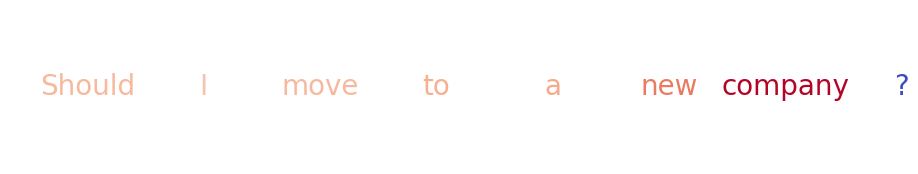

In [13]:
import matplotlib.pyplot as plt
from matplotlib import colors

def get_color(value):
    # Normalize the value between 0 and 1
    norm_value = (value - min(word_values.values())) / (max(word_values.values()) - min(word_values.values()))
    # Create a color map that transitions from red (low) to blue (high)
    cmap = plt.cm.coolwarm
    return colors.rgb2hex(cmap(norm_value))

# Plotting the text with corresponding colors
plt.figure(figsize=(10, 2))
plt.axis('off')

x_pos = 0.1
for word, value in word_values.items():
    plt.text(x_pos, 0.5, word, color=get_color(value), fontsize=20, ha='center', va='center', transform=plt.gca().transAxes)
    x_pos += 0.15  # Adjust spacing between words

plt.show()
